### GPU 9번 설정

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "9" 

In [2]:
import torch

print(torch.cuda.is_available())

True


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 필요 라이브러리 설치

In [4]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import copy
from tqdm import tqdm
import sys, time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision.models import mobilenet_v3_small

import torchvision
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

In [5]:
base_directory = "/home/j-j9s006"

# Data 불러오기

### DF 생성

In [6]:
# 라벨을 숫자로 변환
# labels_to_int = {label: idx for idx, label in enumerate(df['색상'].unique())}
labels_to_int = {'긴팔티': 0, '반팔티': 1, '셔츠/블라우스': 2, '니트웨어': 3, '후드티': 4, '민소매': 5,
                 '긴바지': 6, '반바지': 7, '롱스커트': 8, '미니스커트': 9, 
                 '코트': 10, '재킷': 11, '점퍼/짚업': 12, '패딩': 13, '가디건': 14, '베스트': 15, 
                 '원피스': 16, '점프수트': 17}

# 라벨링된 csv 파일 불러오기
df = pd.read_csv('/home/j-j9s006/type-classification/type_label_crawling.csv')

# 'label' 컬럼에서 빈 값(NaN)을 가진 행 제거
df = df.dropna(subset=['type'])
df['type'] = df['type'].map(labels_to_int)
df['file_path'] = base_directory + "/datasets/type_dataset/"+ df['file_name']

print(df)

            file_name  type                                          file_path
0        jumper_1.png    12  /home/j-j9s006/datasets/type_dataset/jumper_1.png
1     jumper_1000.png    12  /home/j-j9s006/datasets/type_dataset/jumper_10...
2     jumper_1001.png    12  /home/j-j9s006/datasets/type_dataset/jumper_10...
3     jumper_1002.png    12  /home/j-j9s006/datasets/type_dataset/jumper_10...
4     jumper_1003.png    12  /home/j-j9s006/datasets/type_dataset/jumper_10...
...               ...   ...                                                ...
5819      vest_95.png    15   /home/j-j9s006/datasets/type_dataset/vest_95.png
5820      vest_96.png    15   /home/j-j9s006/datasets/type_dataset/vest_96.png
5821      vest_97.png    15   /home/j-j9s006/datasets/type_dataset/vest_97.png
5822      vest_98.png    15   /home/j-j9s006/datasets/type_dataset/vest_98.png
5823      vest_99.png    15   /home/j-j9s006/datasets/type_dataset/vest_99.png

[5824 rows x 3 columns]


In [7]:
# 추가 데이터셋
add_df = pd.read_csv('/home/j-j9s006/type-classification/type_additional_label.csv')

add_df = add_df.dropna(subset=['type'])
add_df['type'] = add_df['type'].map(labels_to_int)
add_df['file_path'] = base_directory + "/datasets/type_additional_dataset/"+ add_df['file_name']

print(add_df)

             file_name  type  \
0     jumper_10008.png    12   
1     jumper_10011.png    12   
2     jumper_10019.png    12   
3     jumper_10023.png    12   
4     jumper_10028.png    12   
...                ...   ...   
2970  vest_k_22821.png    15   
2971  vest_k_22877.png    15   
2972  vest_k_22891.png    15   
2973  vest_k_22892.png    15   
2974  vest_k_25370.png    15   

                                              file_path  
0     /home/j-j9s006/datasets/type_additional_datase...  
1     /home/j-j9s006/datasets/type_additional_datase...  
2     /home/j-j9s006/datasets/type_additional_datase...  
3     /home/j-j9s006/datasets/type_additional_datase...  
4     /home/j-j9s006/datasets/type_additional_datase...  
...                                                 ...  
2970  /home/j-j9s006/datasets/type_additional_datase...  
2971  /home/j-j9s006/datasets/type_additional_datase...  
2972  /home/j-j9s006/datasets/type_additional_datase...  
2973  /home/j-j9s006/datasets/type_

In [8]:
df = pd.concat([df, add_df], ignore_index=True)
# df.dropna(subset=['type'], axis=0, how='any' , inplace=True)

In [9]:
# 숫자를 라벨로 변환
int_to_labels = {v: k for k, v in labels_to_int.items()}
print(int_to_labels)

{0: '긴팔티', 1: '반팔티', 2: '셔츠/블라우스', 3: '니트웨어', 4: '후드티', 5: '민소매', 6: '긴바지', 7: '반바지', 8: '롱스커트', 9: '미니스커트', 10: '코트', 11: '재킷', 12: '점퍼/짚업', 13: '패딩', 14: '가디건', 15: '베스트', 16: '원피스', 17: '점프수트'}


### Custom data 정제 완료

In [10]:
print(df['type'].unique())

[12 17  3  8  9 13  5 14 10  1  4 11 16  6  2  7  0 15]


In [11]:
# type id별로 몇개의 데이터가 있는지 확인
print(df['type'].value_counts())

type
12    655
16    637
6     621
3     618
15    602
13    564
0     532
10    511
14    500
1     493
4     469
2     447
7     430
11    376
9     367
5     336
8     326
17    315
Name: count, dtype: int64


### 이미지 데이터 확인하기

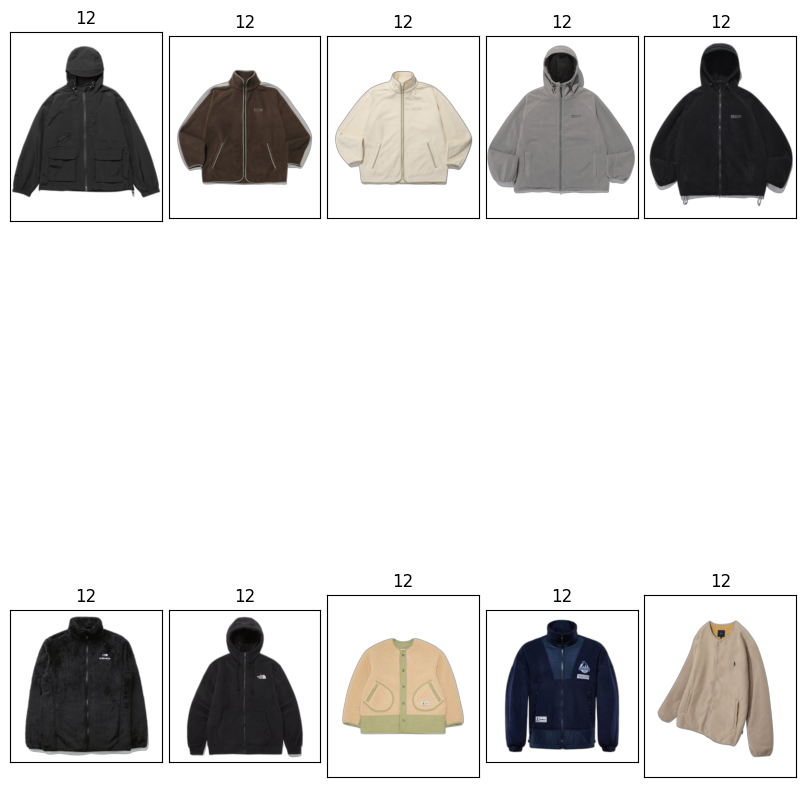

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(os.path.join(base_directory, 'datasets/type_dataset', df['file_name'].iloc[i])))
    ax.set_title(df['type'].iloc[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

### PYTORCH에서 쓰는 방식으로 변경

In [13]:
# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_path, transform=None):
        self.dataframe = dataframe
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = self.image_path[idx]

        image = Image.open(img_path)

        if image.mode == 'RGBA':
            r, g, b, a = image.split()
            bg = Image.new('RGB', image.size, (255,255,255)) # 흰색 배경
            bg.paste(image, mask=a)
            image = bg

        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
# 데이터셋 객체 생성
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(180),
            transforms.RandomResizedCrop((256, 256))
        ], p=0.9),
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

In [15]:
dataset = CustomDataset(dataframe=df, image_path=df['file_path'].tolist(), transform=transform)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Model 생성

In [16]:
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.0.1+cu117
CUDA Version: 11.7


In [17]:
for name in dir(torchvision.models):
    print(name)

AlexNet
AlexNet_Weights
ConvNeXt
ConvNeXt_Base_Weights
ConvNeXt_Large_Weights
ConvNeXt_Small_Weights
ConvNeXt_Tiny_Weights
DenseNet
DenseNet121_Weights
DenseNet161_Weights
DenseNet169_Weights
DenseNet201_Weights
EfficientNet
EfficientNet_B0_Weights
EfficientNet_B1_Weights
EfficientNet_B2_Weights
EfficientNet_B3_Weights
EfficientNet_B4_Weights
EfficientNet_B5_Weights
EfficientNet_B6_Weights
EfficientNet_B7_Weights
EfficientNet_V2_L_Weights
EfficientNet_V2_M_Weights
EfficientNet_V2_S_Weights
GoogLeNet
GoogLeNetOutputs
GoogLeNet_Weights
Inception3
InceptionOutputs
Inception_V3_Weights
MNASNet
MNASNet0_5_Weights
MNASNet0_75_Weights
MNASNet1_0_Weights
MNASNet1_3_Weights
MaxVit
MaxVit_T_Weights
MobileNetV2
MobileNetV3
MobileNet_V2_Weights
MobileNet_V3_Large_Weights
MobileNet_V3_Small_Weights
RegNet
RegNet_X_16GF_Weights
RegNet_X_1_6GF_Weights
RegNet_X_32GF_Weights
RegNet_X_3_2GF_Weights
RegNet_X_400MF_Weights
RegNet_X_800MF_Weights
RegNet_X_8GF_Weights
RegNet_Y_128GF_Weights
RegNet_Y_16GF_We

In [48]:
model = torchvision.models.convnext_small(torchvision.models.ConvNeXt_Small_Weights.DEFAULT)

print(model.classifier)

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)


#### Loss 함수 및 Optimizer 설정

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [51]:
model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

## train test valid 함수

## Train

In [52]:
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # tqdm으로 진행 바 추가
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # 정확도 계산
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}, Accuracy: {accuracy:.2f}%")

print('Finished Training')

100%|██████████| 1980/1980 [02:58<00:00, 11.12it/s]

Epoch 1, Loss: 3.1280241249787686, Accuracy: 6.36%



100%|██████████| 1980/1980 [03:01<00:00, 10.91it/s]

Epoch 2, Loss: 2.9798224484077607, Accuracy: 6.18%



100%|██████████| 1980/1980 [03:01<00:00, 10.92it/s]

Epoch 3, Loss: 2.951870426264676, Accuracy: 6.25%



100%|██████████| 1980/1980 [03:01<00:00, 10.91it/s]

Epoch 4, Loss: 2.9358610784164583, Accuracy: 6.68%



100%|██████████| 1980/1980 [03:16<00:00, 10.07it/s]

Epoch 5, Loss: 2.9275633128002436, Accuracy: 7.24%



100%|██████████| 1980/1980 [03:41<00:00,  8.96it/s]

Epoch 6, Loss: 2.907846454418067, Accuracy: 7.56%



100%|██████████| 1980/1980 [03:40<00:00,  8.96it/s]

Epoch 7, Loss: 2.897579621787023, Accuracy: 7.74%



100%|██████████| 1980/1980 [03:41<00:00,  8.95it/s]

Epoch 8, Loss: 2.8972031507829223, Accuracy: 7.72%



100%|██████████| 1980/1980 [03:40<00:00,  8.98it/s]

Epoch 9, Loss: 2.9002514503218912, Accuracy: 7.51%



100%|██████████| 1980/1980 [03:40<00:00,  9.00it/s]

Epoch 10, Loss: 2.893090080733251, Accuracy: 7.87%



100%|██████████| 1980/1980 [03:40<00:00,  8.99it/s]

Epoch 11, Loss: 2.9023945160586426, Accuracy: 7.45%



100%|██████████| 1980/1980 [03:40<00:00,  8.98it/s]

Epoch 12, Loss: 2.8992148959275448, Accuracy: 7.27%



100%|██████████| 1980/1980 [03:39<00:00,  9.00it/s]

Epoch 13, Loss: 2.8999196877383224, Accuracy: 7.97%



100%|██████████| 1980/1980 [03:38<00:00,  9.04it/s]

Epoch 14, Loss: 2.900773605072137, Accuracy: 7.67%



100%|██████████| 1980/1980 [03:01<00:00, 10.93it/s]

Epoch 15, Loss: 2.8921422813877915, Accuracy: 7.89%



100%|██████████| 1980/1980 [03:00<00:00, 10.97it/s]

Epoch 16, Loss: 2.885302001057249, Accuracy: 7.40%



100%|██████████| 1980/1980 [03:00<00:00, 10.95it/s]

Epoch 17, Loss: 2.8798978127614414, Accuracy: 8.46%



100%|██████████| 1980/1980 [02:59<00:00, 11.00it/s]

Epoch 18, Loss: 2.8819129477847705, Accuracy: 7.96%



100%|██████████| 1980/1980 [03:00<00:00, 10.94it/s]

Epoch 19, Loss: 2.8671370680284016, Accuracy: 9.05%



100%|██████████| 1980/1980 [03:00<00:00, 11.00it/s]


Epoch 20, Loss: 2.882614309980412, Accuracy: 8.92%


100%|██████████| 1980/1980 [02:59<00:00, 11.00it/s]

Epoch 21, Loss: 2.8755702515443167, Accuracy: 8.22%



100%|██████████| 1980/1980 [03:00<00:00, 10.99it/s]

Epoch 22, Loss: 2.870121264096462, Accuracy: 8.66%



100%|██████████| 1980/1980 [03:00<00:00, 10.98it/s]

Epoch 23, Loss: 2.871825210132984, Accuracy: 8.28%



100%|██████████| 1980/1980 [02:59<00:00, 11.02it/s]

Epoch 24, Loss: 2.8633681098620096, Accuracy: 8.75%



100%|██████████| 1980/1980 [03:00<00:00, 10.98it/s]

Epoch 25, Loss: 2.867895903430804, Accuracy: 9.02%



100%|██████████| 1980/1980 [03:00<00:00, 10.98it/s]

Epoch 26, Loss: 2.8706961504136674, Accuracy: 8.92%



100%|██████████| 1980/1980 [02:59<00:00, 11.03it/s]

Epoch 27, Loss: 2.877152126967305, Accuracy: 8.36%



100%|██████████| 1980/1980 [03:00<00:00, 10.97it/s]

Epoch 28, Loss: 2.868112979272399, Accuracy: 8.54%



100%|██████████| 1980/1980 [03:00<00:00, 10.97it/s]

Epoch 29, Loss: 2.873544402194746, Accuracy: 8.66%



100%|██████████| 1980/1980 [02:59<00:00, 11.04it/s]

Epoch 30, Loss: 2.8695583177335333, Accuracy: 8.70%
Finished Training


In [ ]:
from tqdm import tqdm

def test(model, testloader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Gradient 계산을 하지 않음 (테스트 중이므로 필요 없음)
        for i, data in tqdm(enumerate(testloader), total=len(testloader), desc="Testing"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"\nTest Loss: {test_loss/len(testloader)}, Accuracy: {accuracy:.2f}%")
    
    return accuracy, test_loss/len(testloader)

# 이렇게 test 함수를 호출할 수 있습니다:
test_accuracy, test_loss = test(model, testloader, criterion)


In [ ]:
torch.save(model.state_dict(), 'convNext_small_type_v2.pth')

### 추론

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# 라벨을 숫자로 변환
int_to_labels = {0: '긴팔티', 1: '반팔티', 2: '셔츠/블라우스', 3: '니트웨어', 4: '후드티', 5: '민소매', 
                 6: '긴바지', 7: '반바지', 8: '롱스커트', 9: '미니스커트', 10: '코트', 
                 11: '재킷', 12: '점퍼/짚업', 13: '패딩', 14: '가디건', 15: '베스트', 16: '원피스', 17: '점프수트'}

def imshow(img):  
    # 텐서 이미지를 numpy로 변환
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # RGB 형태로 변환하여 출력
    plt.show()
    
transform = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


img_dir = '/home/j-j9s006/color-classification/test_dataset'
list = os.listdir(img_dir)
png_list = [file for file in list if file.endswith(".png")]
test_dataset = []
for img_name in png_list:
    image = Image.open(img_dir + '/' + img_name)
    if image.mode == 'RGBA':
        r, g, b, a = image.split()
        bg = Image.new('RGB', image.size, (255,255,255)) # 흰색 배경
        bg.paste(image, mask=a)
        image = bg
    image = transform(image)
    test_dataset.append(image)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# 모델을 평가 모드로 설정
model = torchvision.models.convnext_small(torchvision.models.ConvNeXt_Small_Weights)
model.load_state_dict(torch.load('convNext_small_type.pth'))  # 학습된 모델의 매개변수 불러오기
model.eval()

with torch.no_grad():
    for images in testloader:        
        outputs = model(images)
        values, indices = torch.topk(outputs, 3)  # 상위 3개의 확률과 인덱스를 가져옴
        
        # 정확도 계산을 위해 가장 높은 확률의 인덱스만 사용
        predicted = indices[:, 0]

        # 이미지와 실제 라벨, 예측치 출력
        imshow(torchvision.utils.make_grid(images))
        top3_labels = [int_to_labels[idx.item()] for idx in indices[0]]
        top3_probs = [val.item() * 100 for val in values[0]]
        print('예측치: ')
        for n in range(3):
            print('%s - %.2f' % (top3_labels[n], top3_probs[n]), end = ' ')
        print()
    
